# Project: Train a Quadcopter How to Fly

Design an agent to fly a quadcopter, and then train it using a reinforcement learning algorithm of your choice! 

Try to apply the techniques you have learnt, but also feel free to come up with innovative ideas and test them.

## Import Libraries
My Note: From given initial file all import parts are moved to this coding block and deleted from the original position. New ones are added.

In [1]:
import random
import csv
import sys
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from task import Task
from agents.Agent import Agent
from agents.policy_search import PolicySearch_Agent
from agents.DDPG_agent import DDPG_Agent

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## Instructions

Take a look at the files in the directory to better understand the structure of the project. 

- `task.py`: Define your task (environment) in this file.
- `agents/`: Folder containing reinforcement learning agents.
    - `policy_search.py`: A sample agent has been provided here.
    - `agent.py`: Develop your agent here.<br>
       My Note: this class file is used as factory, the implemented agent subclass is DDPG_agent.py
- `physics_sim.py`: This file contains the simulator for the quadcopter.  **DO NOT MODIFY THIS FILE**.

For this project, you will define your own task in `task.py`.  Although we have provided an example task to get you started, you are encouraged to change it.  Later in this notebook, you will learn more about how to amend this file.

You will also design a reinforcement learning agent in `agent.py` to complete your chosen task. (see my note above)

You are welcome to create any additional files to help you to organize your code.  For instance, you may find it useful to define a `model.py` file defining any needed neural network architectures.

## Controlling the Quadcopter

We provide a sample agent in the code cell below to show you how to use the sim to control the quadcopter.  This agent is even simpler than the sample agent that you'll examine (in `agents/policy_search.py`) later in this notebook!

The agent controls the quadcopter by setting the revolutions per second on each of its four rotors.  The provided agent in the `Basic_Agent` class below always selects a random action for each of the four rotors.  These four speeds are returned by the `act` method as a list of four floating-point numbers.  

For this project, the agent that you will implement in `agents/agent.py` will have a far more intelligent method for selecting actions!

In [2]:
class Basic_Agent():
    def __init__(self, task):
        self.task = task
    
    def act(self):
        new_thrust = random.gauss(450., 25.)
        return [new_thrust + random.gauss(0., 1.) for x in range(4)]

Run the code cell below to have the agent select actions to control the quadcopter.  

Feel free to change the provided values of `runtime`, `init_pose`, `init_velocities`, and `init_angle_velocities` below to change the starting conditions of the quadcopter.

The `labels` list below annotates statistics that are saved while running the simulation.  All of this information is saved in a text file `data.txt` and stored in the dictionary `results`.  

In [3]:
# Modify the values below to give the quadcopter a different starting position.
runtime = 5.                                     # time limit of the episode
init_pose = np.array([0., 0., 10., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
file_output = 'data.txt'                         # file name for saved results

# Setup
task = Task(init_pose, init_velocities, init_angle_velocities, runtime)
agent = Basic_Agent(task)
done = False
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

# Run the simulation, and save the results.
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    while True:
        rotor_speeds = agent.act()
        _, _, done = task.step(rotor_speeds)
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        if done:
            break

Run the code cell below to visualize how the position of the quadcopter evolved during the simulation.

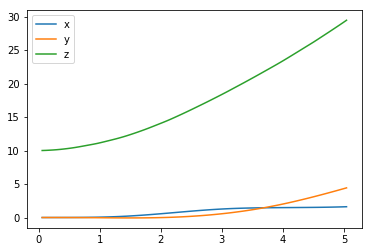

In [4]:
plt.plot(results['time'], results['x'], label='x')
plt.plot(results['time'], results['y'], label='y')
plt.plot(results['time'], results['z'], label='z')
plt.legend()
_ = plt.ylim()

The next code cell visualizes the velocity of the quadcopter.

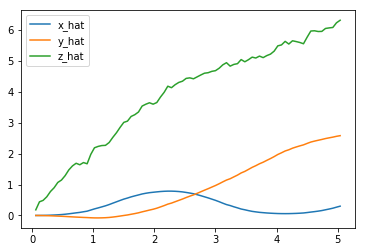

In [5]:
plt.plot(results['time'], results['x_velocity'], label='x_hat')
plt.plot(results['time'], results['y_velocity'], label='y_hat')
plt.plot(results['time'], results['z_velocity'], label='z_hat')
plt.legend()
_ = plt.ylim()

Next, you can plot the Euler angles (the rotation of the quadcopter over the $x$-, $y$-, and $z$-axes),

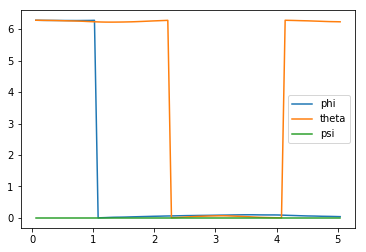

In [6]:
plt.plot(results['time'], results['phi'], label='phi')
plt.plot(results['time'], results['theta'], label='theta')
plt.plot(results['time'], results['psi'], label='psi')
plt.legend()
_ = plt.ylim()

before plotting the velocities (in radians per second) corresponding to each of the Euler angles.

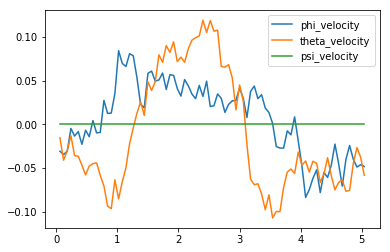

In [7]:
plt.plot(results['time'], results['phi_velocity'], label='phi_velocity')
plt.plot(results['time'], results['theta_velocity'], label='theta_velocity')
plt.plot(results['time'], results['psi_velocity'], label='psi_velocity')
plt.legend()
_ = plt.ylim()

Finally, you can use the code cell below to print the agent's choice of actions.  

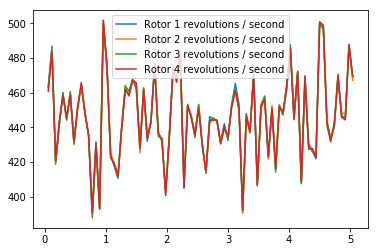

In [8]:
plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1 revolutions / second')
plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2 revolutions / second')
plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3 revolutions / second')
plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4 revolutions / second')
plt.legend()
_ = plt.ylim()

When specifying a task, you will derive the environment state from the simulator.  Run the code cell below to print the values of the following variables at the end of the simulation:
- `task.sim.pose` (the position of the quadcopter in ($x,y,z$) dimensions and the Euler angles),
- `task.sim.v` (the velocity of the quadcopter in ($x,y,z$) dimensions), and
- `task.sim.angular_v` (radians/second for each of the three Euler angles).

In [9]:
# the pose, velocity, and angular velocity of the quadcopter at the end of the episode
print(task.sim.pose)
print(task.sim.v)
print(task.sim.angular_v)

[ 1.61081809  4.42710282 29.45512887  0.04050865  6.23352756  0.        ]
[0.30119657 2.58303841 6.318108  ]
[-0.04810474 -0.05815217  0.        ]


In the sample task in `task.py`, we use the 6-dimensional pose of the quadcopter to construct the state of the environment at each timestep.  However, when amending the task for your purposes, you are welcome to expand the size of the state vector by including the velocity information.  You can use any combination of the pose, velocity, and angular velocity - feel free to tinker here, and construct the state to suit your task.

## The Task

A sample task has been provided for you in `task.py`.  Open this file in a new window now. 

The `__init__()` method is used to initialize several variables that are needed to specify the task.  
- The simulator is initialized as an instance of the `PhysicsSim` class (from `physics_sim.py`).  
- Inspired by the methodology in the original DDPG paper, we make use of action repeats.  For each timestep of the agent, we step the simulation `action_repeats` timesteps.  If you are not familiar with action repeats, please read the **Results** section in [the DDPG paper](https://arxiv.org/abs/1509.02971).
- We set the number of elements in the state vector.  For the sample task, we only work with the 6-dimensional pose information.  To set the size of the state (`state_size`), we must take action repeats into account.  
- The environment will always have a 4-dimensional action space, with one entry for each rotor (`action_size=4`). You can set the minimum (`action_low`) and maximum (`action_high`) values of each entry here.
- The sample task in this provided file is for the agent to reach a target position.  We specify that target position as a variable.

The `reset()` method resets the simulator.  The agent should call this method every time the episode ends.  You can see an example of this in the code cell below.

The `step()` method is perhaps the most important.  It accepts the agent's choice of action `rotor_speeds`, which is used to prepare the next state to pass on to the agent.  Then, the reward is computed from `get_reward()`.  The episode is considered done if the time limit has been exceeded, or the quadcopter has travelled outside of the bounds of the simulation.

In the next section, you will learn how to test the performance of an agent on this task.

## The Agent

The sample agent given in `agents/policy_search.py` uses a very simplistic linear policy to directly compute the action vector as a dot product of the state vector and a matrix of weights. Then, it randomly perturbs the parameters by adding some Gaussian noise, to produce a different policy. Based on the average reward obtained in each episode (`score`), it keeps track of the best set of parameters found so far, how the score is changing, and accordingly tweaks a scaling factor to widen or tighten the noise.

Run the code cell below to see how the agent performs on the sample task.

In [10]:
num_episodes = 1000
target_pos = np.array([0., 0., 10.])
task = Task(target_pos=target_pos)
agent = PolicySearch_Agent(task) 

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(reward, done)
        state = next_state   
             
        if done:
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {}".format(
                i_episode, agent.score, agent.best_score, agent.noise_scale), end="")  # [debug]
            break
    sys.stdout.flush()

Episode = 1000, score =  -1.216 (best =   0.180), noise_scale = 3.2555

This agent should perform very poorly on this task.  And that's where you come in!

## Define the Task, Design the Agent, and Train Your Agent!

Amend `task.py` to specify a task of your choosing.  If you're unsure what kind of task to specify, you may like to teach your quadcopter to takeoff, hover in place, land softly, or reach a target pose.  

After specifying your task, use the sample agent in `agents/policy_search.py` as a template to define your own agent in `agents/agent.py`.  You can borrow whatever you need from the sample agent, including ideas on how you might modularize your code (using helper methods like `act()`, `learn()`, `reset_episode()`, etc.).

Note that it is **highly unlikely** that the first agent and task that you specify will learn well.  You will likely have to tweak various hyperparameters and the reward function for your task until you arrive at reasonably good behavior.

As you develop your agent, it's important to keep an eye on how it's performing. Use the code above as inspiration to build in a mechanism to log/save the total rewards obtained in each episode to file.  If the episode rewards are gradually increasing, this is an indication that your agent is learning.

In [14]:
## TODO: Train your agent here.

# Default initialisation is:
# runtime = 5.                                     # time limit of the episode
# init_pose = np.array([0., 0., 10., 0., 0., 0.])  # initial pose
# init_velocities = np.array([0., 0., 0.])         # initial velocities
# init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
take_off_file_output = 'take-off_DDPG_data.csv'    # file name for saved results

#
# Setup
#
num_episodes = 1000 
init_velocities = np.array([0., 0., 0.])

# status information for different configuration types "default", "mod"
#status = "default"
status = "mod"
params = None

if status is "mod":
    # change DDPG agent parameters used for learning
    
    # technical from task class
    # we are interested in the z position, so, the psi velocity is relevant
    init_velocities = np.array([0., 0., 10.])  # first try: [0., 0., 10.], second: [0., 0., 20.], third [0., 0., 10.]
    
    # from agent initialisation:
    #    - alpha: actor learning rate
    #    - beta: critic learning rate
    #    - gamma: discount value, for termination function: final state with gamma(s)=0
    #    - tau: used for smooth shifting from the local prediction models to the target models (soft update of targets)
    #    - mu, theta, sigma: for creation of Ornstein-Uhlenbeck noise instance, part of exploration policy creation
    #    - max_size: memory buffer size
    params = {'alpha' : 0.0001,
              'beta'  : 0.001,
              'gamma' : 0.9,
              'tau'   : 0.01,
              'mu'    : 0.3,
              'theta' : 0.15,
              'sigma' : 0.3,
              'max_size' : 100000}
    
# for task    
target_pos = np.array([0., 0., 30.])               # target z position for take-off task (tested 20, 30)
task_name = "take-off"
task = Task(target_pos=target_pos, init_velocities=init_velocities, name=task_name)       

# for agent
type_name = "DDPG"
agent = Agent(task, type_name, params).get_agent()  # returns DDPG_agent instance
labels = ['episode','time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
done = False

# Result log file
results = {x : [] for x in labels}
# Total rewards
total_rewards = []
# Best reward
best_reward = 0

#
# Run the simulation, and save the results.
#
with open(take_off_file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    
    for i_episode in range(1, num_episodes+1):
        state = agent.reset_episode() # start a new episode
        total_reward = 0
        while True:
            action = agent.act(state) 
            next_state, reward, done = task.step(action)
        
            # calculation of total_reward
            total_reward += reward
            # all info for the task data csv file to have the choice of further data analysis, not only reward
            to_write = [i_episode] + [task.sim.time] + list(task.sim.pose)+ list(task.sim.v) + \
                       list(task.sim.angular_v) + list(rotor_speeds)
            agent.step(action, reward, next_state, done)
            state = next_state
            
            for i_label in range(len(labels)):
                results[labels[i_label]].append(to_write[i_label])
                writer.writerow(to_write)
        
            if done:
                if (total_reward > best_reward):
                    best_reward = total_reward
                
                total_rewards.append(total_reward)
                print("\rEpisode: {}, total reward: {:7.3f}, best reward: {:7.3f}".format(i_episode,
                                                                                          total_reward, best_reward),
                      end="")  # [debug]
                #print(to_write)
                break
    sys.stdout.flush()


--- Actor ---
How much layers has the model?  15
--- Build model summary of DQNetwork: ---
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 16)                304       
_________________________________________________________________
dense_24 (Dense)             (None, 32)                544       
_________________________________________________________________
batch_normalization_19 (Batc (None, 32)                128       
_________________________________________________________________
activation_21 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 64)                2112      
__________________________________________________


--- Critic ---

--- Build model summary of TargetNetwork: ---
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
states (InputLayer)             (None, 18)           0                                            
__________________________________________________________________________________________________
actions (InputLayer)            (None, 4)            0                                            
__________________________________________________________________________________________________
dense_39 (Dense)                (None, 32)           608         states[0][0]                     
__________________________________________________________________________________________________
dense_42 (Dense)                (None, 32)           160         actions[0][0]                    
______________________________________________

In [15]:
# create new dataframe for total reward  of task take-off
rewards_dict = {'total_reward' : total_rewards}
rewards_df = pd.DataFrame(data = rewards_dict)
print("---  Take-off: Total Rewards dataframe ---")
print("reward maximum: {}\nits index: {}".format(rewards_df.max(), rewards_df.idxmax()))

# store the resulting dataframe of the rewards information and their configuration
# first case: default config of DDPG agent
if status is "default":
    defaults_df = pd.DataFrame({'alpha' : 0.0001,
                            'beta'  : 0.001,
                            'gamma' : 0.9,
                            'tau'   : 0.125 ,
                            'mu'    : 0.2,
                            'theta' : 0.15,
                            'sigma' : 0.2,
                            'max_size' : 100000
                            }, index=[0])
    defaults_df.to_csv("./results/default_DDPG_config.csv", index=False)
    rewards_df.to_csv("./results/take-off_DDPG_rewards_1000episodes_defaultConfig_initV-0010.csv", index=False)
elif status is "mod":
    modConfig_1_df = pd.DataFrame(params, index=[0])
    modConfig_1_df.to_csv("./results/mod_DDPG_config_3.csv", index=False)
    rewards_df.to_csv("./results/take-off_DDPG_rewards_1000episodes_modConfig3_initV-0010.csv", index=False)


---  Take-off: Total Rewards dataframe ---
reward maximum: total_reward    19859.383777
dtype: float64
its index: total_reward    283
dtype: int64


In [16]:
# the pose, velocity, and angular velocity of the quadcopter at the end of the 'take-off' training
print(task.sim.pose)
print(task.sim.v)
print(task.sim.angular_v)

[-10.60563991 -55.98351995  43.11136514   3.56002129   2.08841222
   0.        ]
[ -0.80110269 -20.41945122   3.00123015]
[ 28.83635134 -28.84189478   0.        ]


## Plot the Rewards

Once you are satisfied with your performance, plot the episode rewards, either from a single run, or averaged over multiple runs. 

In [ ]:
# My note:
# for future version it shall be possible to do further analysis about reward and technical data
# because of project deadline: this additional, not required feature could not be realised now
# 
# e.g. having the technical data for each episode, a new dataframe object with their average info
# together with the associated total reward of this episode could be used

# specific plot utility for csv files
#def plot_stats(csv_filename, columns=['total_reward'], **kwargs):
#    """Plot specified columns from CSV file."""
#    df_stats = pd.read_csv(csv_filename)
#    df_stats[columns].plot(**kwargs)

# Load the csv file 'take-off_DDPG_data.csv' which is part of the same directory as the notebook file
#try:
#    df_takeoff = pd.read_csv('take-off_DDPG_data.csv')
#except FileNotFoundError:
#    print("The csv file 'take-off_DDPG_data.csv' does not exist in the given directory. No analysis possible.")


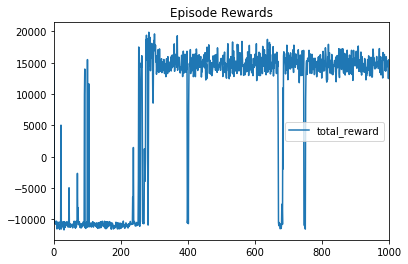

In [17]:
## TODO: Plot the episode rewards.
 
# new dataframe of total_rewards data is used for plotting
# x = episodes, y = reward amount
rewards_df[['total_reward']].plot(title='Episode Rewards')

In [24]:
# Calculation of mean reward values of the final rewards dataframe instance

# Rewards mean of the last 10 episodes
last_10_reward_df = rewards_df.tail(10)
#print("The mean value of the last 10 episodes is: {:7.3f}".format(last_10_reward_df.mean(axis=0)))
last_10_reward_df.describe()

,total_reward
count,10.000000
mean,14744.469514
std,1034.778673
min,12472.303874
25%,14450.105763
50%,14924.419831
75%,15411.353282
max,15958.684687


In [23]:
# Rewards mean of the last 50 episodes
last_50_reward_df = rewards_df.tail(50)
#print("The mean value of the last 10 episodes is: {:7.3f}".format(last_10_reward_df.mean(axis=0)))
last_50_reward_df.describe()

,total_reward
count,50.000000
mean,14871.565011
std,1089.482163
min,12472.303874
25%,14164.870193
50%,14924.419831
75%,15499.773371
max,17252.140622


## Reflections

**Question 1**: Describe the task that you specified in `task.py`.  How did you design the reward function?

**Answer**:<br>
For this project the **take-off task** has been chosen. For the simulation this means, the quadcopter shall start from a specific position at the ground, then lift off and flying to reach a configured target position. Important about this target is the height - in other words the positions z value. If the drone has reached such specific height value, the episode ends and a positive reward is given during that phase. A negative reward is given, if this target height has been exceeded. The velocity configuration is included proportionally to calculate the final reward value. For the positive reward it has a higher influence.

This specification is implemented in the task class as new function get_TakeOff_reward(self):<br>
`
if self.sim.pose[2] > self.target_pos[2]:
    reward = -20.0 * 1/3 * self.sim.v[2]
else:
    reward = 30.0 * 2/3 * self.sim.v[2]
`

For this constraint 'end of eposide' - means reaching the z value -, all other technical values, like x- or y- values or velocity or others, are irrelevant.

For the tasks reward behaviour, they are important, but have not all been included yet (only velocity). So, as future toDo, there could be different penalties be implemented as well, like drift effects or if the quadcopter trundles or is tumbling down or crashes completely.

Some more details according task specification are mentioned in chapter _Chosen Task: take-off_ of this additionally written [document](https://github.com/IloBe/RL_Quadcopter_master/blob/master/RL_architecture_info.pdf).

**Question 2**: Discuss your agent briefly, using the following questions as a guide:

- What learning algorithm(s) did you try? What worked best for you?
- What was your final choice of hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc.)?
- What neural network architecture did you use (if any)? Specify layers, sizes, activation functions, etc.

**Answer**:<br>
This quadcopter project is a domain example of complex tasks of sensory input. This means, we are working with continuous and highdimensional action spaces and having a regression problem that shall be solved with a
reinforcement learning method.

For the project domain, the quadcopter shall autonomously achieve the control about the chosen take-off task. To reach this simulated physics task and to find a high performant policy a specific reinforcement learning concept is implemented, called **actor-critic method** using _deep Q-learning neural networks_ and lower-dimensional action spaces. The concept combines the advantages of Policy Gradient and DQNs.<br>
Such model-free, off-policy actor-critic method using deep function approximators is choosen, because it can learn policies for such high-dimensional, continuous domain action spaces best according the mentioned DDPG paper.

Overview of the architecture is shown [here](https://github.com/IloBe/RL_Quadcopter_master/blob/master/RL-actor-critic_architecture.PNG) (Source: http://people.csail.mit.edu/hongzi/content/publications/DeepRM-HotNets16.pdf).

In this project, this kind of actor-critic network is implemented with batch-normalisation, dropout layers, final sigmoid activation function and Adam as optimiser. For each model component, means actor and critic, a local model and a target model is created used during training and the associated DDPG agent works with Deep Deterministic Policy Gradient method to reach the target goal by getting a good policy with high convergence.

Regarding the networks:<br>
Their structure and layer size is logged during the training code block process (see above).

For the **actor**, the models input states are mapped to output actions, they are used to update the policy function π(a|s,θ).<br>
- specific model information:<br>
  -- the Keras Sequential() model concept is used<br>
  -- states are given as input for the input layer<br>
  -- in the hidden layers,<br> 
     for stabilisation BatchNormalization() instances and
     to avoid overfitting Dropout() instances are added<br>
  -- the output layer delivers one node for each action of the action space and<br>
     because of using a sigmoid activation function, its output range [0, 1] is scaled<br>
  -- the project implementation is a regression issue,<br>
     therefore the learning process is configured with Adam as optimiser and a mean backend loss function

For the **critic**, the models input state-action pairs are mapped to output q values.<br>
- specific model information:<br>
  -- because of having 2 foundation layers for states and actions input, the Keras Model()-layer concept is used<br>
  -- in the hidden layers,<br> 
     for stabilisation BatchNormalization() instances and
     to avoid overfitting Dropout() instances are added<br>
  -- as final output layer for Q-values Dense() is used<br>
  -- the learning configuration is implemented with Adam optimiser and mean squared error as loss function<br>
  -- finally, with Keras backend concept a function is created to get action gradients to be used by the actor model

The **final parameters** are:
- ground position: position array [0., 0., 10.]
- target height: position array [0., 0., 30.]: an evaluation with a lower hight value has the consequence of being instable as well, the reward - episode diagrams showed no stable learning
- Velocity has a big influence: it has been decided to put this init value to [0., 0., 10.], because [0., 0., 20.] leads the quadcopter being very instable with mainly negative rewards. In other words, the drone exceeded the target height mostly.
- the tau value used for smooth shifting (soft target update) has been updated from 0.125 to 0.01
- noise values have been changed either from lower mu and sigma values to higher ones
- the final settings for the last plot are<br>
  'alpha' : 0.0001, 'beta' : 0.001, 'gamma' : 0.9, 'tau' : 0.01, 'mu' : 0.3, 'theta' : 0.15, 'sigma' : 0.3 and
  'max_size' : 100000
   
Nevertheless, the results are not optimal and it is expected that there is a better combination of parameters to avoid the few big negative rewards after episode size >300. To deliver a proper set of parameters would be easier, if there is a good understanding of the domain physical properties and their dependencies. With this knowledge the quadcopter could be set on a validated stable basic configuration.

**Question 3**: Using the episode rewards plot, discuss how the agent learned over time.

- Was it an easy task to learn or hard?
- Was there a gradual learning curve, or an aha moment?
- How good was the final performance of the agent? (e.g. mean rewards over the last 10 episodes)

**Answer**:<br>
Sorry, but in this context I cannot answer the first question properly, because 'easy' is an abstract word and no requirements are mentioned to define what you mean by using the word 'easy'.

So let as assume, 'easy' means the task has been learned during the first 300 episodes, then the answer would be yes, because the device learned the task during such period. Approximately, between episodes 220 and 300 it has a kind of aha moment. There was no constant increasing learning curve. After haveing reached the training goal, mainly a constant high reward value remains, means the device is mainly stable, with the exception of 3 situations.

If we assume, 'easy' means the task has been learned constantly during the first 200 episodes, then the answer would be no, because at the beginning during the first 100 episodes there is a constant up and down. For the next 100 episodes the device has a low reward, so, it does not reach the training goal and has always exceeded the z value target position.

At the end, the quadcopter has learned the task most of the time. The mean reward values of the last 10 and last 50 episodes is nearly the same and the 50% percentile is the same:
- last 10 episodes: 14744.469514
- last 50 episodes: 14871.565011
- 50% percentile for both: 14924.419831

Unfortunately, during the learned task period the device failed three times. Therefore, the final set of parameters is good, but not perfect.

**Question 4**: Briefly summarize your experience working on this project. You can use the following prompts for ideas.

- What was the hardest part of the project? (e.g. getting started, plotting, specifying the task, etc.)
- Did you find anything interesting in how the quadcopter or your agent behaved?

**Answer**:<br>
Reading about the project content and having the course material in mind, it was clear that the solution should be an actor-critic method with a deep Q-learning neural network. Some of the details and how to start the implementation was mentioned in the project documentation. But everything is only understandable by knowing the technical domain. So, for me the hardest part of the project has been the domain issue with task selection and specification.

It is clear that not knowing anything about the quadcopter domain, it is difficult to create a detailed specification of a general labelled task like 'take-off' or 'landing'. Specific detailed knowledge about i.a. geography landscape and weather aspects, mechanical and electrical or other technical properties, user behaviour, device maintenance and the dependencies from and with all such topics have to be taken into account. Not having in mind all the needed mathematical, physical and chemical knowledge for writing proper and useful documentation about it.

What does this mean for the quadcopter software implementation?

Let us assume knowing a lot of things of this domain. Anyway, it would be a huge and time consuming requirement engineering process to create such software task specifications for all use cases, as it is generally necessary for software architecture design, implementation and testing. 

With reinforcement learning there is no need to do that in details, because it is an inherent major property of reinforcement learning „to train an agent by telling it what the desired goal is instead of how to reach it“: See [here](http://mkoval.org/projects/quadrotor/files/quadrotor-rl.pdf) as starting point paper _Autonomous Quadrotor Control with Reinforcement Learning_ from Koval, Mansley and Littman. Such abstraction clearly simplified this projects software realisation, but it is still not easy.<br>
Additionally, starting with writing down the RL concept, the software architecture content and technical domain information helpded a lot to ease the implementation work. This [document](https://github.com/IloBe/RL_Quadcopter_master/blob/master/RL_architecture_info.pdf) is stored in the associated GitHub repository as well.

Creating own agent, actor, critic classes from the scratch, was only possible with the in the current chapter _Task_ mentioned DDPG paper of the  ICLR conference from 2016 _Continuous Control With Deep Reinforcement Learning_ from the Google DeepMind team (London, UK). With such paper it was more clear what components shall be available and how the algorithm should look like. Nevertheless, doing the first own implementation of such kind of deep neural network and the associated reinforcement learning method took some time.

Working on the first Udacity project of this machine learning part 2 course - dog breed classifier - was helpful, because already there some examination about network architectures has happened. So, BatchNormalizer() and Dropout() layers have been added at once, also the usage of the Adam optimiser.

Regarding the training results, at the beginning, I have expected that the best reward score would change by changing the DDPG agent parameters, but with the first reward function specification, it always has been on the same level value (7560.0) by having the same velocity value. It was different, by changing the physical task parameter velocity. With velocity change drastic behaviour and reward ranges appeared. Means, velocity shall not be changed to higher values in big steps and its value has been added to the reward function proportionally after having had this insight.
Afterwards, mainly the noise parameter changes have led to the final result.

Furthermore, because of time pressure not all ideas and insights (e.g. additional TakeOff_task subclass as factory design pattern and its penalty handling) could be implemented. There is still an open toDo list.

...
